In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [2]:
class GeradorDeNumerosAleatorios():
    def __init__(self, semente: int, a: int, c: int, m: int):
        self.semente = semente
        self.a = a
        self.c = c
        self.m = m

        self.ultimoGerado = semente

    @staticmethod
    def ObterFatoresPrimos(numero: int) -> set:
        """
        Calcula os fatores primos de um determinado número.
        Retorna um conjunto (set) com os fatores.
        """
        fatores = set()
        divisor = 2

        # Reduz o número por seus fatores de 2
        while numero % divisor == 0:
            fatores.add(divisor)
            numero //= divisor

        # Agora testa divisores ímpares
        divisor = 3
        while divisor * divisor <= numero:
            while numero % divisor == 0:
                fatores.add(divisor)
                numero //= divisor
            divisor += 2

        # Se o número restante for primo e maior que 2
        if numero > 2:
            fatores.add(numero)

        return fatores

    @staticmethod
    def EncontrarParesHullDobell(moduloM: int, numPares: int) -> list[tuple[int, int]]:
        """
        Procura exaustivamente por pares (a, c) que satisfazem o Teorema de Hull-Dobell
        para um dado módulo M, resultando em um Gerador Linear Congruencial de período máximo.

        Args:
            moduloM (int): O módulo 'M' do gerador.
            numPares (int): O número de pares (a, c) a serem encontrados.
                            Se for 0, procura por todos os pares possíveis.

        Returns:
            list[tuple[int, int]]: Uma lista de tuplas, onde cada tupla é um par (a, c) válido.
        """
        if moduloM <= 1:
            print("O módulo M deve ser maior que 1.")
            return []

        paresEncontrados = []

        # Pré-calcula os fatores primos de M para otimização
        fatoresPrimosDeM = GeradorDeNumerosAleatorios.ObterFatoresPrimos(moduloM)
        print(f"Módulo M = {moduloM}")
        print(f"Fatores primos de M: {fatoresPrimosDeM if fatoresPrimosDeM else 'Nenhum'}\n")

        # A barra de progresso irá iterar de 0 a M-1
        # O desc é a descrição que aparece ao lado da barra
        for a in tqdm(range(moduloM), desc=f"Procurando pares (a,c) para M={moduloM}"):
            # Condição 2 e 3 (dependem apenas de 'a')
            aMenosUm = a - 1

            # --- Verificação da Condição 3 ---
            # Se M é múltiplo de 4, a-1 também deve ser.
            if moduloM % 4 == 0 and aMenosUm % 4 != 0:
                continue # Falhou, vai para o próximo 'a'

            # --- Verificação da Condição 2 ---
            # a-1 deve ser divisível por todos os fatores primos de M
            condicao2Satisfeita = True
            for fator in fatoresPrimosDeM:
                if aMenosUm % fator != 0:
                    condicao2Satisfeita = False
                    break # Se falhar para um fator, não precisa testar os outros

            if not condicao2Satisfeita:
                continue # Falhou, vai para o próximo 'a'

            # Se 'a' passou nas condições, agora testamos 'c'
            for c in range(moduloM):
                # --- Verificação da Condição 1 ---
                # mdc(c, M) deve ser 1
                if math.gcd(c, moduloM) == 1:
                    # Se chegou aqui, o par (a, c) é válido!
                    paresEncontrados.append((a, c))

                    # Se já encontramos o número de pares desejado (e não é 0)
                    if numPares != 0 and len(paresEncontrados) >= numPares:
                        print(f"\nBusca concluída. {len(paresEncontrados)} pares encontrados.")
                        return paresEncontrados

        print(f"\nBusca concluída. {len(paresEncontrados)} pares encontrados.")
        return paresEncontrados

    def GerarAleatorios(self, n):
        ultimoGerado = self.semente
        numeros = pd.DataFrame(columns=["i", 'Número Gerado', 'Número Normalizado'])

        for i in range(0, n):
            ultimoGerado = (self.a * ultimoGerado + self.c) % self.m
            numeros = pd.concat([numeros, pd.DataFrame({'i': [i], 'Número Gerado': [ultimoGerado], 'Número Normalizado': [ultimoGerado / self.m]})], ignore_index=True)

        numeros.plot(x='i', y='Número Normalizado', kind='scatter')

        return numeros

    def GerarProximoAleatorio(self):
        self.ultimoGerado = (self.a * self.ultimoGerado + self.c) % self.m
        return self.ultimoGerado / self.m

class Simulador:
    def __init__(self, gerador: GeradorDeNumerosAleatorios, parada: float, numeroDeServidores: int, tamanhoDaFila: int, variacaoNoTempoDeChegada: tuple, variacaoNoTempoDeSaida: tuple, comecarEm: float):
        # Assumimos que 'parada' é o tempo total de simulação (horizonte de tempo)
        self.gerador = gerador
        self.parada = float(parada)
        self.numeroDeServidores = int(numeroDeServidores)
        self.tamanhoDaFila = int(tamanhoDaFila)
        self.variacaoNoTempoDeChegada = variacaoNoTempoDeChegada
        self.variacaoNoTempoDeSaida = variacaoNoTempoDeSaida
        self.comecarEm = float(comecarEm)

        self.eventos: list[Simulador.Evento] = []
        self.fila = self.Fila(tamanhoDaFila)
        self.perdas: int = 0
        self.tempoTotalDaExecucao: float = 0.0
        self.tempoAtual: float = 0.0
        self.servidoresOcupados: int = 0

        # tempo em cada tamanho de fila (0..tamanhoDaFila)
        self.tempoDeExecucaoPorPosicoesOcupadas: list[float] = [0.0 for _ in range(0, tamanhoDaFila + 1)]

        # primeiro evento de chegada
        self.eventos.append(self.Evento("chegada", self.comecarEm))

    class Evento:
        def __init__(self, tipo: str, tempo: float):
            self.tipo = tipo
            self.tempo = float(tempo)

    class Fila:
        def __init__(self, tamanho: int):
            self.tamanho = int(tamanho)
            self.posicoesOcupadas = 0  # apenas os clientes aguardando (não inclui em serviço)

    def Simular(self):
        # Executa até o tempo de parada; eventos após esse tempo são ignorados
        while True:
            evento = self.ProximoEvento()
            if evento is None:
                break

            if evento.tempo > self.parada:
                # Acumula o tempo restante até a parada no estado atual e encerra
                self._AcumulaTempoAte(self.parada)
                break

            if evento.tipo == "chegada":
                self.ProcessaEventoDeChegada(evento)
            elif evento.tipo == "saida":
                self.ProcessaEventoDeSaida(evento)
            else:
                # ignora tipos desconhecidos
                pass

        self.tempoTotalDaExecucao = self.tempoAtual
        return self.Resultados()

    def ProcessaEventoDeChegada(self, evento):
        # Atualiza tempos até o momento do evento
        self._AcumulaTempoAte(evento.tempo)

        # Agenda próxima chegada
        proximaChegada = self.tempoAtual + self.EstimaTempo("chegada")
        if proximaChegada <= self.parada:
            self.eventos.append(self.Evento("chegada", proximaChegada))

        # Tenta iniciar serviço imediatamente
        if self.servidoresOcupados < self.numeroDeServidores:
            self.servidoresOcupados += 1
            tempoDeServico = self.EstimaTempo("saida")
            self.eventos.append(self.Evento("saida", self.tempoAtual + tempoDeServico))
        else:
            # Entra na fila se houver espaço; caso contrário, perda
            if self.fila.posicoesOcupadas < self.fila.tamanho:
                self.fila.posicoesOcupadas += 1
            else:
                self.perdas += 1

    def ProcessaEventoDeSaida(self, evento):
        # Atualiza tempos até o momento do evento
        self._AcumulaTempoAte(evento.tempo)

        if self.fila.posicoesOcupadas > 0:
            # Retira um cliente da fila e inicia seu serviço imediatamente
            self.fila.posicoesOcupadas -= 1
            tempoDeServico = self.EstimaTempo("saida")
            self.eventos.append(self.Evento("saida", self.tempoAtual + tempoDeServico))
        else:
            # Libera um servidor
            if self.servidoresOcupados > 0:
                self.servidoresOcupados -= 1

    def ProximoEvento(self):
        if not self.eventos:
            return None
        idx = min(range(len(self.eventos)), key=lambda i: self.eventos[i].tempo)
        return self.eventos.pop(idx)

    def _AcumulaTempoAte(self, novoTempo: float):
        # Acumula tempo no estado atual (tamanho da fila) entre tempoAtual e novoTempo
        delta = novoTempo - self.tempoAtual
        if delta > 0:
            self.tempoDeExecucaoPorPosicoesOcupadas[self.fila.posicoesOcupadas] += delta
            self.tempoAtual = novoTempo

    def EstimaTempo(self, tipo: str):
        if tipo == "chegada":
            inicio = self.variacaoNoTempoDeChegada[0]
            fim    = self.variacaoNoTempoDeChegada[1]
            return (fim - inicio) * self.gerador.GerarProximoAleatorio() + inicio
        elif tipo == "saida":
            inicio = self.variacaoNoTempoDeSaida[0]
            fim    = self.variacaoNoTempoDeSaida[1]
            return (fim - inicio) * self.gerador.GerarProximoAleatorio() + inicio
        else:
            return 0.0

    def ProbabilidadesPorPosicoes(self) -> list[float]:
        total = self.tempoTotalDaExecucao if self.tempoTotalDaExecucao > 0 else 0.0
        if total == 0.0:
            return [0.0 for _ in self.tempoDeExecucaoPorPosicoesOcupadas]
        return [t / total for t in self.tempoDeExecucaoPorPosicoesOcupadas]

    def Resultados(self):
        return {
            "tempoTotalDaExecucao": self.tempoTotalDaExecucao,
            "tempoDeExecucaoPorPosicoesOcupadas": self.tempoDeExecucaoPorPosicoesOcupadas,
            "probabilidades": self.ProbabilidadesPorPosicoes(),
            "perdas": self.perdas,
            "servidoresOcupados": self.servidoresOcupados,
            "filaAtual": self.fila.posicoesOcupadas,
        }

C:\Users\gabri\AppData\Local\Temp\ipykernel_17244\3181080794.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  numeros = pd.concat([numeros, pd.DataFrame({'i': [i], 'Número Gerado': [ultimoGerado], 'Número Normalizado': [ultimoGerado / self.m]})], ignore_index=True)


,i,Número Gerado,Número Normalizado
0,0,1025555898,0.238781
1,1,3923423697,0.913493
2,2,2630631676,0.612492
3,3,3981355051,0.926981
4,4,211918734,0.049341
5,5,3675562389,0.855784
6,6,1550419440,0.360985
7,7,228089999,0.053106
8,8,295425186,0.068784
9,9,4225977241,0.983937


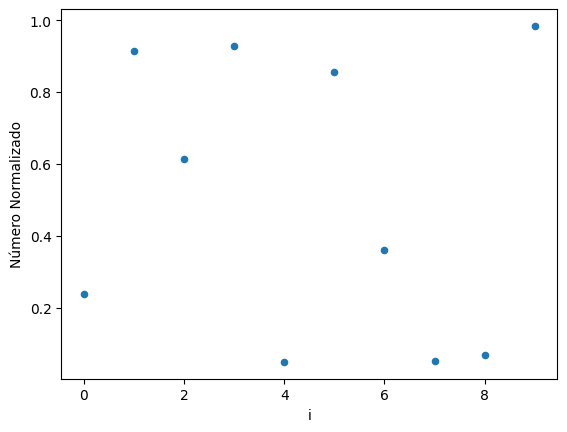

In [ ]:
# Exemplo rápido de uso do simulador
# Parâmetros: 1 servidor, fila de capacidade 5, chegadas ~ U[1,3], serviços ~ U[0.5,1.5], simulação até t=500

gerador = GeradorDeNumerosAleatorios(semente = 7, a = 1664525, c = 1013904223, m = 4294967296)
sim = Simulador(
    gerador=gerador,
    parada=500.0,
    numeroDeServidores=1,
    tamanhoDaFila=5,
    variacaoNoTempoDeChegada=(1.0, 3.0),
    variacaoNoTempoDeSaida=(0.5, 1.5),
    comecarEm=0.0
)
res = sim.Simular()

print("Tempo total de execução:", res["tempoTotalDaExecucao"])
print("Tempo por posições ocupadas:", res["tempoDeExecucaoPorPosicoesOcupadas"])
print("Probabilidades por posições ocupadas:", res["probabilidades"])
print("Perdas:", res["perdas"])

In [ ]:
gerador2 = GeradorDeNumerosAleatorios(semente = 7, a = 1664525, c = 1013904223, m = 4294967296)

for i in range(0, 10):
    numero = gerador2.GerarProximoAleatorio()
    print(numero)



0.23878083983436227
0.9134932646993548
0.6124916663393378
0.9269814591389149
0.049341175239533186
0.8557835568208247
0.3609851561486721
0.05310634127818048
0.06878403620794415
0.9839370010886341


In [3]:
# Execução dos cenários solicitados

def simular_e_mostrar(nome, servidores, fila, chegada, servico, parada=10000.0):
    print(f"\n=== {nome} ===")
    gerador = GeradorDeNumerosAleatorios(
        semente=7, a=1664525, c=1013904223, m=4294967296
    )
    sim = Simulador(
        gerador=gerador,
        parada=float(parada),
        numeroDeServidores=int(servidores),
        tamanhoDaFila=int(fila),
        variacaoNoTempoDeChegada=tuple(map(float, chegada)),
        variacaoNoTempoDeSaida=tuple(map(float, servico)),
        comecarEm=0.0,
    )
    res = sim.Simular()

    tempo_total = res["tempoTotalDaExecucao"]
    tempos = res["tempoDeExecucaoPorPosicoesOcupadas"]
    probs = res["probabilidades"]

    print(f"Tempo total de execução: {tempo_total:.2f}")
    print(f"Perdas: {res['perdas']}")

    print("Probabilidades por número de posições ocupadas na fila (0..{}):".format(len(probs)-1))
    for i, p in enumerate(probs):
        print(f"  {i}: {p:.4f}")

# Cenário 1: 1 servidor, fila 5, chegadas U[2,5], serviço U[3,5]
simular_e_mostrar(
    nome="Cenário 1: 1 servidor, fila 5, chegadas [2,5], atendimento [3,5]",
    servidores=1,
    fila=5,
    chegada=(2, 5),
    servico=(3, 5),
    parada=10000.0,
)

# Cenário 2: 2 servidores, fila 5, chegadas U[2,5], serviço U[3,5]
simular_e_mostrar(
    nome="Cenário 2: 2 servidores, fila 5, chegadas [2,5], atendimento [3,5]",
    servidores=2,
    fila=5,
    chegada=(2, 5),
    servico=(3, 5),
    parada=10000.0,
)


=== Cenário 1: 1 servidor, fila 5, chegadas [2,5], atendimento [3,5] ===
Tempo total de execução: 10000.00
Perdas: 362
Probabilidades por número de posições ocupadas na fila (0..5):
  0: 0.0004
  1: 0.0036
  2: 0.0056
  3: 0.0486
  4: 0.5089
  5: 0.4328

=== Cenário 2: 2 servidores, fila 5, chegadas [2,5], atendimento [3,5] ===
Tempo total de execução: 10000.00
Perdas: 0
Probabilidades por número de posições ocupadas na fila (0..5):
  0: 0.9992
  1: 0.0008
  2: 0.0000
  3: 0.0000
  4: 0.0000
  5: 0.0000
